# Статистический анализ данных

## Описание проекта

Имеются данные о некоторых пользователях популярного сервиса аренды самокатов GoFast из нескольких городов, а также об их поездках. <br>
Чтобы совершать поездки по городу, пользователи сервиса GoFast пользуются мобильным приложением. <br>
Сервисом можно пользоваться с подпиской и без нее.<br>

Необходимо проанализировать данные и проверить следующие гипотезы:
1. тратят ли пользователи с подпиской больше времени на поездки;
2. можно ли сказать, что среднее расстояние, которое проезжают пользователи с подпиской за одну поездку, не превышает 3130 метров;
3. будет ли помесячная выручка от пользователей с подпиской по месяцам выше, чем выручка от пользователей без подписки.<br>

Выяснить, какое минимальное количество промокодов нужно разослать при проведении акции на один бесплатный месяц подписки, чтобы как минимум 100 существующих клиентов продлили эту подписку.<br>
Эта акция уже проводилась ранее и по итогу выяснилось, что после бесплатного пробного периода подписку продлевают 10 % пользователей. <br>
Допустимая вероятность не выполнить план примерно 5 %.<br>

Оценить вероятность того, что при рассылке 1 млн push-уведомлений клиентам в мобильном приложении, уведомление откроют не более 399,5 тыс. пользователей. Известно, что уведомления открывают около 40 % получивших клиентов.


<b>Описание данных</b>

users_go.csv - информация о пользователях <br>
user_id	уникальный идентификатор пользователя<br>
name - имя пользователя<br>
age - возраст<br>
city - город<br>
subscription_type - тип подписки (free, ultra)<br>

rides_go.csv - информация о поездках<br>
user_id	- уникальный идентификатор пользователя<br>
distance - расстояние, которое пользователь проехал в текущей сессии (в метрах)<br>
duration - продолжительность сессии (в минутах) — время с того момента, как пользователь нажал кнопку «Начать поездку» до момента, как он нажал кнопку «Завершить поездку»<br>
date - дата совершения поездки<br>

subscriptions_go.csv - информация о подписках<br>
subscription_type - тип подписки<br>
minute_price - стоимость одной минуты поездки по данной подписке<br>
start_ride_price - стоимость начала поездки<br>
subscription_fee - стоимость ежемесячного платежа<br>


## Загрузка данных

In [1]:
#импортируем библиотеки
import pandas as pd
import numpy as np
import datetime as dt
import matplotlib.pyplot as plt
from scipy import stats as st

In [2]:
#Загружаем данные из csv-файлом в датафреймы 
df_users = pd.read_csv('/datasets/users_go.csv')
df_users.head()

,user_id,name,age,city,subscription_type
0,1,Кира,22,Тюмень,ultra
1,2,Станислав,31,Омск,ultra
2,3,Алексей,20,Москва,ultra
3,4,Константин,26,Ростов-на-Дону,ultra
4,5,Адель,28,Омск,ultra


In [3]:
df_users.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1565 entries, 0 to 1564
Data columns (total 5 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   user_id            1565 non-null   int64 
 1   name               1565 non-null   object
 2   age                1565 non-null   int64 
 3   city               1565 non-null   object
 4   subscription_type  1565 non-null   object
dtypes: int64(2), object(3)
memory usage: 61.3+ KB


Информация о пользователях содержит 1565 строк. Пропусков нет.

In [4]:
#информация о поездках
df_rides = pd.read_csv('/datasets/rides_go.csv')
df_rides.head()

,user_id,distance,duration,date
0,1,4409.919140,25.599769,2021-01-01
1,1,2617.592153,15.816871,2021-01-18
2,1,754.159807,6.232113,2021-04-20
3,1,2694.783254,18.511000,2021-08-11
4,1,4028.687306,26.265803,2021-08-28


In [5]:
df_rides.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18068 entries, 0 to 18067
Data columns (total 4 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   user_id   18068 non-null  int64  
 1   distance  18068 non-null  float64
 2   duration  18068 non-null  float64
 3   date      18068 non-null  object 
dtypes: float64(2), int64(1), object(1)
memory usage: 564.8+ KB


Информация о поездках содержит 18068 строк. Пропусков нет. Тип данных столбца с информацией о датах необходимо преобразовать в Datetime

In [6]:
#информация о подписках
df_subscriptions = pd.read_csv('/datasets/subscriptions_go.csv')
df_subscriptions.head()

,subscription_type,minute_price,start_ride_price,subscription_fee
0,free,8,50,0
1,ultra,6,0,199


## Предобработка данных

In [7]:
#преобразуем тип данных в столобце date      
df_rides['date']=pd.to_datetime(df_rides['date'], format='%Y-%m-%d')
df_rides['date'].head()

0   2021-01-01
1   2021-01-18
2   2021-04-20
3   2021-08-11
4   2021-08-28
Name: date, dtype: datetime64[ns]

In [8]:
#проверим за какой период у нас имеются данные
print('Данные о поездках содержат информацию за период с', df_rides['date'].min(), 'по', df_rides['date'].max())

Данные о поездках содержат информацию за период с 2021-01-01 00:00:00 по 2021-12-30 00:00:00


In [9]:
#создадим новый столбец с месяцем поездки
df_rides['ride_month'] = df_rides['date'].dt.month
df_rides.head()

,user_id,distance,duration,date,ride_month
0,1,4409.919140,25.599769,2021-01-01,1
1,1,2617.592153,15.816871,2021-01-18,1
2,1,754.159807,6.232113,2021-04-20,4
3,1,2694.783254,18.511000,2021-08-11,8
4,1,4028.687306,26.265803,2021-08-28,8


In [10]:
df_rides.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18068 entries, 0 to 18067
Data columns (total 5 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   user_id     18068 non-null  int64         
 1   distance    18068 non-null  float64       
 2   duration    18068 non-null  float64       
 3   date        18068 non-null  datetime64[ns]
 4   ride_month  18068 non-null  int64         
dtypes: datetime64[ns](1), float64(2), int64(2)
memory usage: 705.9 KB


In [11]:
#проверим данные на наличие дубликатов и удалим их при наличии
df_rides.duplicated().sum()

0

In [12]:
df_subscriptions.duplicated().sum()

0

In [13]:
df_users.duplicated().sum()

31

In [14]:
df_users = df_users.drop_duplicates()
df_users.duplicated().sum()

0

В полученных данных пропусков не обнаружено. В данных о пользователях удален 31 дубликат.<br> 
После обработки данные о пользователях содержат информацию о 1534 клиентах.<br>
Данные о поездках содержат информацию о 18068 поездках за период с 01.01.2021 по 30.12.2021. <br>
Информация о подписках содержит 2 вида оплаты за пользование самокатом: с подпиской (ultra) и без нее (free).

## Исследовательский анализ данных

### Частота встречаемости городов

In [15]:
#посчитаем кол-во пользователей в каждом городе
df_users['city'].value_counts()

Пятигорск         219
Екатеринбург      204
Ростов-на-Дону    198
Краснодар         193
Сочи              189
Омск              183
Тюмень            180
Москва            168
Name: city, dtype: int64

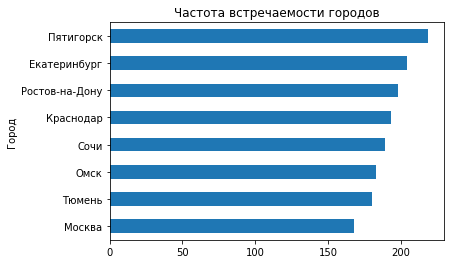

In [16]:
df_users['city'].value_counts(ascending=True).plot(
    kind='barh',
    xlabel = 'Город',
    ylabel = 'Количество пользователей',
    title = 'Частота встречаемости городов');

In [17]:
#посчитаем относительное распределение пользователей по городам
df_users['city'].value_counts(normalize=True).round(3)*100

Пятигорск         14.3
Екатеринбург      13.3
Ростов-на-Дону    12.9
Краснодар         12.6
Сочи              12.3
Омск              11.9
Тюмень            11.7
Москва            11.0
Name: city, dtype: float64

Данные содержат информацию о 1534 пользователях из 8 городов.Больше всего пользователей находится в Пятигорске (219 чел. или 14.3%). Меньше всего - в Москве (168 чел. или 11%). 

### Анализ информации о возрасте пользователей

In [18]:
df_users['age'].describe()

count    1534.000000
mean       24.903520
std         4.572367
min        12.000000
25%        22.000000
50%        25.000000
75%        28.000000
max        43.000000
Name: age, dtype: float64

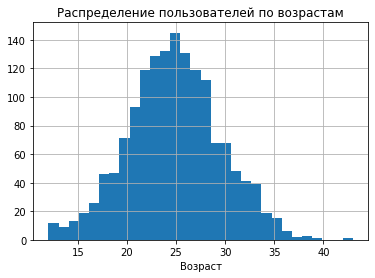

In [19]:
df_users['age'].hist(bins=30)
plt.title("Распределение пользователей по возрастам")
plt.xlabel('Возраст');

Возраст пользователей варьируется от 12 до 43 лет. Основная часть (77%) находится в возрасте от 20 до 30 лет. Средний возраст пользователей - 25 лет.

### Cоотношение пользователей с подпиской и без подписки

In [20]:
#посчитаем соотношение пользователей с подпиской и без подписки
df_users.loc[df_users['subscription_type']=='free','user_id'].count()/df_users.loc[df_users['subscription_type']=='ultra','user_id'].count()

1.1945636623748213

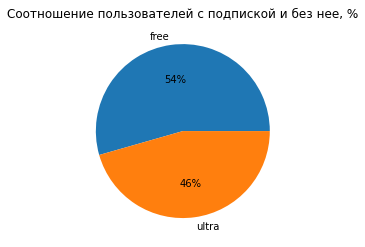

In [21]:
df_users.groupby('subscription_type')['user_id'].count().plot(kind='pie', 
        title='Соотношение пользователей с подпиской и без нее, %',
        ylabel='', autopct='%1.0f%%');

Пользователей без подписки в 1,19 раз больше, чем пользователе1й с подпиской и составляет 54% от общего количества пользователей.

### Анализ данных о расстоянии, которое пользователь преодолел за одну поездку

In [22]:
#расстояние, которое пользователь преодолел за одну поездку
df_rides['distance'].describe()

count    18068.000000
mean      3070.659976
std       1116.831209
min          0.855683
25%       2543.226360
50%       3133.609994
75%       3776.222735
max       7211.007745
Name: distance, dtype: float64

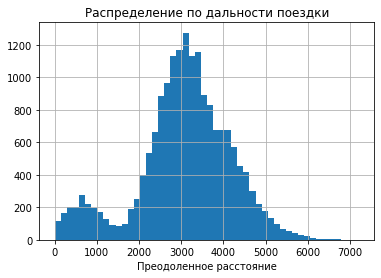

In [23]:
df_rides['distance'].hist(bins=50)
plt.title("Распределение по дальности поездки")
plt.xlabel('Преодоленное расстояние');

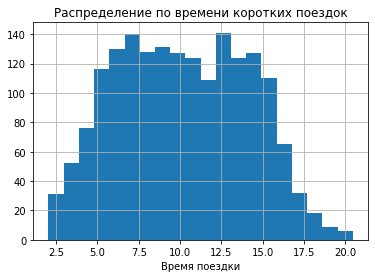

In [24]:
#посмотрим отдельно на распределение по времени коротких поездок
df_rides.query('distance<1500').hist('duration', bins=20)
plt.title('Распределение по времени коротких поездок')
plt.xlabel('Время поездки');

Основная часть пользователей проезжает от 2,5 до 3,8 км за одну поездку. Среднее расстояние составляет около 3,1 км. <br>
Однако на гистограмме есть еще небольшой пик при значении около 800 м, соответствующий небольшим поездкам, что может быть связано с использованием самоката для быстрого передвижения на небольшие расстояния (например, быстро добраться до ж/д станции или магазина) или "пробами" новичков (поездки с низкой скоростью на небольшие расстояния).

### Анализ данных о продолжительнотси поездок

In [25]:
df_rides['duration'].describe()

count    18068.000000
mean        17.805011
std          6.091051
min          0.500000
25%         13.597563
50%         17.678395
75%         21.724800
max         40.823963
Name: duration, dtype: float64

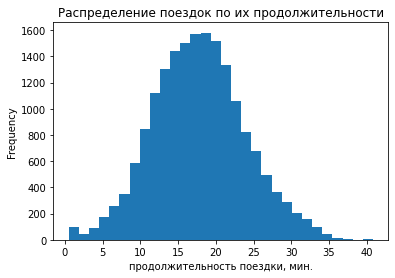

In [26]:
df_rides['duration'].plot(kind='hist',bins=30, title ='Распределение поездок по их продолжительности')
plt.xlabel('продолжительность поездки, мин.');

Длительность одной поездки варьируется от 0,5 до 41 минуты. Минимальное знаечние в 0.5 минуты слишком мало для поездки. Проверим, какое расстояние указано для поездок меньше минуты.

In [27]:
df_rides.query('duration<1').sort_values(by='distance')

,user_id,distance,duration,date,ride_month
15132,1325,4030.308008,0.5,2021-12-22,12
17909,1524,4103.998874,0.5,2021-06-18,6
10692,1006,4106.278268,0.5,2021-10-31,10
9698,937,4169.066800,0.5,2021-12-12,12
14342,1268,4177.139336,0.5,2021-06-09,6
...,...,...,...,...,...
14574,1285,6316.574814,0.5,2021-09-25,9
13701,1224,6414.516026,0.5,2021-07-15,7
11385,1057,6601.197575,0.5,2021-02-07,2
17242,1477,6724.932981,0.5,2021-01-12,1


In [28]:
df_rides.query('duration<1').duration.unique()

array([0.5])

В целом длительность поездки лежит в диапазоне от 2 до 40 минут. Основная часть пользователей тратит на одну поездку от 13 до 22 минут. Однако в данных присутствует 95 поездок длительностью 0,5 минуты и преодоленным расстоянием более 4 км.Необходимо уточнение:возможно таким образом была реализована акция с бесплатными минутами или это ошибка выгрузки данных.

### Объединение данных

In [29]:
#Объединим данные о пользователях, поездках и подписках в один датафрейм
df = df_users.merge(df_rides, on='user_id')
df

,user_id,name,age,city,subscription_type,distance,duration,date,ride_month
0,1,Кира,22,Тюмень,ultra,4409.919140,25.599769,2021-01-01,1
1,1,Кира,22,Тюмень,ultra,2617.592153,15.816871,2021-01-18,1
2,1,Кира,22,Тюмень,ultra,754.159807,6.232113,2021-04-20,4
3,1,Кира,22,Тюмень,ultra,2694.783254,18.511000,2021-08-11,8
4,1,Кира,22,Тюмень,ultra,4028.687306,26.265803,2021-08-28,8
...,...,...,...,...,...,...,...,...,...
18063,1534,Альберт,25,Краснодар,free,3781.098080,19.822962,2021-11-04,11
18064,1534,Альберт,25,Краснодар,free,2840.423057,21.409799,2021-11-16,11
18065,1534,Альберт,25,Краснодар,free,3826.185507,18.435051,2021-11-18,11
18066,1534,Альберт,25,Краснодар,free,2902.308661,16.674362,2021-11-27,11


In [30]:
df = df.merge(df_subscriptions, on='subscription_type')
df

,user_id,name,age,city,subscription_type,distance,duration,date,ride_month,minute_price,start_ride_price,subscription_fee
0,1,Кира,22,Тюмень,ultra,4409.919140,25.599769,2021-01-01,1,6,0,199
1,1,Кира,22,Тюмень,ultra,2617.592153,15.816871,2021-01-18,1,6,0,199
2,1,Кира,22,Тюмень,ultra,754.159807,6.232113,2021-04-20,4,6,0,199
3,1,Кира,22,Тюмень,ultra,2694.783254,18.511000,2021-08-11,8,6,0,199
4,1,Кира,22,Тюмень,ultra,4028.687306,26.265803,2021-08-28,8,6,0,199
...,...,...,...,...,...,...,...,...,...,...,...,...
18063,1534,Альберт,25,Краснодар,free,3781.098080,19.822962,2021-11-04,11,8,50,0
18064,1534,Альберт,25,Краснодар,free,2840.423057,21.409799,2021-11-16,11,8,50,0
18065,1534,Альберт,25,Краснодар,free,3826.185507,18.435051,2021-11-18,11,8,50,0
18066,1534,Альберт,25,Краснодар,free,2902.308661,16.674362,2021-11-27,11,8,50,0


In [31]:
#Округляем данные о продолжительности поездок
df['duration'] = np.ceil(df['duration'])
df.head()

,user_id,name,age,city,subscription_type,distance,duration,date,ride_month,minute_price,start_ride_price,subscription_fee
0,1,Кира,22,Тюмень,ultra,4409.919140,26.0,2021-01-01,1,6,0,199
1,1,Кира,22,Тюмень,ultra,2617.592153,16.0,2021-01-18,1,6,0,199
2,1,Кира,22,Тюмень,ultra,754.159807,7.0,2021-04-20,4,6,0,199
3,1,Кира,22,Тюмень,ultra,2694.783254,19.0,2021-08-11,8,6,0,199
4,1,Кира,22,Тюмень,ultra,4028.687306,27.0,2021-08-28,8,6,0,199


In [32]:
#создадим 2 датафрейма отдельно c данными о пользователях с подпиской и без нее
df_free = df.query('subscription_type=="free"')
df_ultra = df.query('subscription_type=="ultra"')

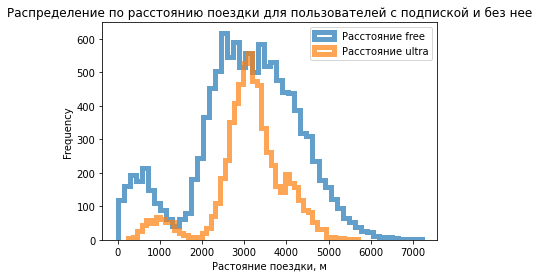

In [33]:
#визуализируем информацию о расстоянии по категориям
ax=df_free.plot(kind='hist', histtype='step', y='distance', bins=50, linewidth=5, alpha=0.7, label='Расстояние free')
ax=df_ultra.plot(kind='hist', histtype='step', y='distance', bins=50, linewidth=5, alpha=0.7, label='Расстояние ultra', ax=ax)
plt.title('Распределение по расстоянию поездки для пользователей с подпиской и без нее')
plt.xlabel('Растояние поездки, м');

In [34]:
df_free['distance'].describe()

count    11568.000000
mean      3045.495282
std       1246.173806
min          0.855683
25%       2366.562689
50%       3114.648465
75%       3905.697894
max       7211.007745
Name: distance, dtype: float64

In [35]:
df_ultra['distance'].describe()

count    6500.000000
mean     3115.445388
std       836.895330
min       244.210438
25%      2785.444017
50%      3148.637229
75%      3560.574425
max      5699.769662
Name: distance, dtype: float64

Расстояние, преодоленное за одну поездку для обеих категорий пользователей распределено примерно одинаково. Однако, разброс значений для расстояния, преодалеваемого пользователями без подписки больше, чем для пользователей с подпиской. 

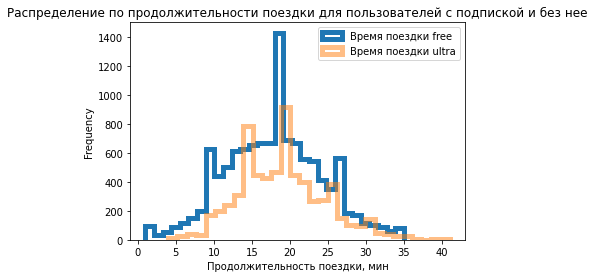

In [36]:
#визуализируем информацию о времени поездок по категориям
ax=df_free.plot(kind='hist', histtype='step', y='duration', bins=30, linewidth=5, label='Время поездки free')
ax=df_ultra.plot(kind='hist',y='duration', histtype='step', bins=30, linewidth=5, alpha=0.5,label='Время поездки ultra',ax=ax)
plt.title('Распределение по продолжительности поездки для пользователей с подпиской и без нее')
plt.xlabel('Продолжительность поездки, мин');

Время поездки для обеих категорий пользователей распределено примерно одинаково. Однако, максимальное время поездки у пользователей с подпиской больше, чем у пользователей без нее.

In [37]:
df_free['duration'].describe()

count    11568.000000
mean        17.890992
std          6.330250
min          1.000000
25%         13.000000
50%         18.000000
75%         22.000000
max         35.000000
Name: duration, dtype: float64

In [38]:
df_ultra['duration'].describe()

count    6500.000000
mean       19.037692
std         5.577439
min         4.000000
25%        15.000000
50%        19.000000
75%        22.000000
max        41.000000
Name: duration, dtype: float64

### Подсчёт выручки

Создадим датафрейм с агрегированными данными о поездках для каждого пользователя: 
найдем суммарное расстояние, количество поездок, суммарное время за каждый месяц, месячную выручка по каждому пользователю.

In [39]:
#агрегируем данные и рассчитываем доход
df_sum = (df.groupby(['user_id','ride_month','minute_price','start_ride_price','subscription_fee','subscription_type'])
            .agg({'distance':'sum','duration':'sum','date':'count'}).reset_index())
df_sum = df_sum.rename(columns={'date':'rides_quantity','distance':'dist_sum','duration':'duration_sum'})
df_sum['earning'] = df_sum['duration_sum']*df_sum['minute_price']\
                          +df_sum['start_ride_price']*df_sum['rides_quantity']\
                          +df_sum['subscription_fee']
df_sum.head(10)

,user_id,ride_month,minute_price,start_ride_price,subscription_fee,subscription_type,dist_sum,duration_sum,rides_quantity,earning
0,1,1,6,0,199,ultra,7027.511294,42.0,2,451.0
1,1,4,6,0,199,ultra,754.159807,7.0,1,241.0
2,1,8,6,0,199,ultra,6723.470560,46.0,2,475.0
3,1,10,6,0,199,ultra,5809.911100,32.0,2,391.0
4,1,11,6,0,199,ultra,7003.499363,56.0,3,535.0
5,1,12,6,0,199,ultra,6751.629942,28.0,2,367.0
6,2,3,6,0,199,ultra,10187.723006,63.0,3,577.0
7,2,4,6,0,199,ultra,6164.381824,40.0,2,439.0
8,2,6,6,0,199,ultra,3255.338202,14.0,1,283.0
9,2,7,6,0,199,ultra,6780.722964,48.0,2,487.0


In [40]:
#делим данные на 2 части по наличию подписки
df_free_sum = df_sum.query('subscription_type=="free"')
df_ultra_sum = df_sum.query('subscription_type=="ultra"')

## Проверка гипотез

### Гипотеза 1

Проверим тратят ли пользователи с подпиской больше времени на поездки.<br>
H0: пользователи с подпиской и без нее тратят одинаковое время на поездки.<br>
H1: пользователи с подпиской тратят больше времени на поездки, чем пользователи без подписки.<br>
Уровень статистической значимости 5%.

In [41]:
alpha = 0.05
results = st.ttest_ind(df_ultra['duration'], df_free['duration'],alternative='greater') 
print('p-значение:', results.pvalue)
if (results.pvalue < alpha):
    print('Отвергаем нулевую гипотезу')
else:
    print('Не отвергаем нулевую гипотезу') 

p-значение: 2.4959453720736625e-34
Отвергаем нулевую гипотезу


Получаем, что пользователи с подпиской действительно тратят больше времени на поездки.

In [42]:
print('Cредняя продолжительность поездок пользователей с подпиской', df_ultra['duration'].mean().round(),'минут')
print('Cредняя продолжительность поездок пользователей без подписки', df_free['duration'].mean().round(),'минут')

Cредняя продолжительность поездок пользователей с подпиской 19.0 минут
Cредняя продолжительность поездок пользователей без подписки 18.0 минут


### Гипотеза 2

Проверим правильно ли предположение, что пользователи с подпиской в среднем проезжают за одну поездку не более 3130 метров.<br>
H0: пользователи с подпиской проезжают в среднем 3130 метров за одну поездку. <br>
H1: пользователи с подпиской проезжают в среднем более 3130 метров за одну поездку. <br>
Уровень статистической значимости 5%.

In [43]:
df_ultra['distance'].describe()

count    6500.000000
mean     3115.445388
std       836.895330
min       244.210438
25%      2785.444017
50%      3148.637229
75%      3560.574425
max      5699.769662
Name: distance, dtype: float64

In [44]:
alpha = 0.05
dist = 3130
results = st.ttest_1samp(df_ultra['distance'], dist, alternative='greater') 
print('p-значение:', results.pvalue)
if (results.pvalue<alpha):
    print('Отвергаем нулевую гипотезу: расстояние превышает 3130 метров')
else:
    print('Не получилось отвергнуть нулевую гипотезу: расстояние не превышает 3130 метров')

p-значение: 0.9195368847849785
Не получилось отвергнуть нулевую гипотезу: расстояние не превышает 3130 метров


Мы не можем отвергнуть нулевую гипотезу в сторону альтернативной гипотезы о том, что пользователи проезжают больше 3130 метров за одну поездку. Следовательно, предположение, что в среднем они проезжают не более 3130 метров можно считать верным.

### Гипотеза 3

Проверим,будет ли помесячная выручка от пользователей с подпиской выше, чем выручка от пользователей без подписки.<br>
H0: выручки равны<br>
H1: выручка от пользователей с подпиской больше, чем выручка от пользователей без подписки<br>
Уровень статистической значимости 5%.

In [45]:
alpha = 0.05
results = st.ttest_ind(df_ultra_sum['earning'],df_free_sum['earning'],alternative='greater') 
print('p-значение:', results.pvalue)
if (results.pvalue < alpha):
    print('Отвергаем нулевую гипотезу. Ежемесячная выручка от пользователей с подпиской выше')
else:
    print('Не отвергаем нулевую гипотезу') 

p-значение: 1.8850394384715216e-31
Отвергаем нулевую гипотезу. Ежемесячная выручка от пользователей с подпиской выше


In [46]:
print('Cреднемесячная выручка от пользователей с подпиской', df_ultra_sum['earning'].mean().round(),'руб.')
print('Cреднемесячная выручка от пользователей без подписки', df_free_sum['earning'].mean().round(),'руб.')

Cреднемесячная выручка от пользователей с подпиской 363.0 руб.
Cреднемесячная выручка от пользователей без подписки 329.0 руб.


## Распределения

<b>Задача 1</b>

Отделу маркетинга нужно провести акцию с раздачей промокодов на один бесплатный месяц подписки, в рамках которой как минимум 100 существующих клиентов должны продлить эту подписку. То есть по завершении периода действия подписки пользователь может либо отказаться от неё, либо продлить, совершив соответствующий платёж. 
Эта акция уже проводилась ранее и по итогу выяснилось, что после бесплатного пробного периода подписку продлевают 
10 % пользователей. 
Необходимо выяснить, какое минимальное количество промокодов нужно разослать, чтобы вероятность не выполнить план была примерно 5 %.

Для данного эксперименте проводятся независимые испытания с двумя исходами - продлить подписку или отказаться от нее, что соответствует биноминальному распределению. Чтобы при верояности успеха 10% получить 100 подписок необходим расолать не менее 1000 промокодов.
Количество испытаний n=1000, вероятность успеха = 0,1.

/opt/conda/lib/python3.9/site-packages/scipy/stats/_discrete_distns.py:78: RuntimeWarning: divide by zero encountered in _binom_pdf
  return _boost._binom_pdf(x, n, p)


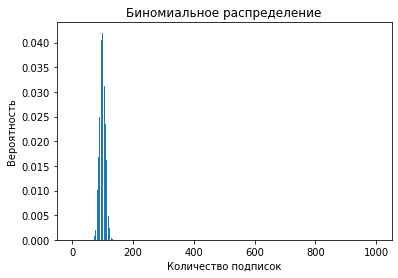

In [47]:
n=1000
p=0.1

distr = []

for k in range(0, n + 1):
    current_value = st.binom.pmf(k, n, p)
    distr.append(current_value)
   
plt.bar(range(0, n + 1), distr)
plt.title ('Биномиальное распределение')
plt.xlabel('Количество подписок')
plt.ylabel('Вероятность');
plt.show()


Распределение близко к номральному. Проверим, что его можно аппроксимировать нормальным распределением.

In [48]:
mu = n*p
sigma = (n*p*(1-p))**0.5
# границы промежутка, в котором будем строить аппроксимацию -
# от n*p минус 3 ст.отклонения бином.распределения
# до n*p плюс 3 ст.отклонения бином.распределения
left = int(n * p - 3 * (n * p * (1 - p))**0.5)
right = int(n * p + 3 * (n * p * (1 - p))**0.5)
print('Леваяграница',left)
print('Праваяграница', right)


Леваяграница 71
Праваяграница 128


Отрезок аппроксимации лежит внутри отрезка, на котором определено биноминальное распределение. 

In [49]:
distr_app = st.norm(mu, sigma)
xmin=100
result=1-distr_app.cdf(xmin)
result

0.5

При рассылке 1000 промокодов вероятность получить 100 подписок равна 50%. Будем увеличивать количество промокодов с шагом в 20 шт. для поиска необходимого количества промокодов.

In [50]:
for i in range(1,20):
    n = 1000+i*10
    mu = n*p
    sigma = (n*p*(1-p))**0.5
    distr_app = st.norm(mu, sigma)
    xmin=100
    result=1-distr_app.cdf(xmin)
    print (n, result)


1010 0.541766917246966
1020 0.5826749521227874
1030 0.622323353484773
1040 0.660361201893336
1050 0.6964944226198999
1060 0.7304898355979456
1070 0.7621763696429296
1080 0.7914437190269021
1090 0.8182388308211437
1100 0.84256067933179
1110 0.8644538113916442
1120 0.884001138185633
1130 0.9013164126003091
1140 0.916536773681788
1150 0.9298156696141634
1160 0.9413163950131069
1170 0.9512064034722397
1180 0.9596524870212627
1190 0.966816853804489


При количестве промокодов, равным 1170 шт., вероятность получить менее 100 подписок составляет 95.1%, что соответствует условию. 

<b>Задача 2</b>

Отдел маркетинга планирует разослать клиентам 1 млн push-уведомлений в мобильном приложении. Известно, что уведомления открывают около 40 % получивших клиентов.  
Необходимо оценить вероятность того, что уведомление откроют не более 399,5 тыс. пользователей.

Для данного эксперименте проводятся независимые испытания с двумя исходами - открыть уведомление или нет, что соответствует биноминальному распределению.
Количество испытаний =1000000, вероятность успеха = 0,4.

In [51]:
#проверим возможность аппроксмации нормальным распределением
#параметры биномиального распределения
n1 = 1000000
p1 = 0.4
#параметры нормального распределения
mu1 = n1*p1
sigma1 = (n1*p1*(1-p1))**0.5
# границы промежутка, в котором будем строить аппроксимацию -
# от n*p минус 3 ст.отклонения бином.распределения
# до n*p плюс 3 ст.отклонения бином.распределения
left1 = int(n1 * p1 - 4 * (n1 * p1 * (1 - p1))**0.5)
right1 = int(n1 * p1 + 4 * (n1 * p1 * (1 - p1))**0.5)
print('Леваяграница',left1)
print('Праваяграница', right1)

Леваяграница 398040
Праваяграница 401959


Отрезок аппрокисмации лежит внутри отрезка, на котором определено распределение

In [52]:
# для визуализации нормального распределения
# зададим функцию, которая выдаёт <num> чисел,
# равномерно распределённых от <start> до <stop>

def linspace(start, stop, num):
    step = (stop - start) / (num - 1)
    res = []
    for i in range(num):
        res.append(start + step * i)
    return res

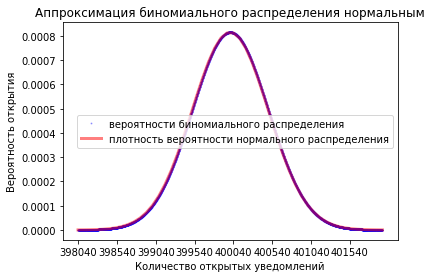

In [53]:
# зададим набор значений биномиальной величины на выбранном промежутке
x = list(range(max(0, left1), right1))
ax = plt.subplot()
ax.plot(x, st.binom.pmf(x, n1, p1), 'bo', ms=1, alpha=0.3, label='вероятности биномиального распределения')
# рисуем график нормального распределения
x = linspace(left1, right1, 50)

ax.plot(x, st.norm.pdf(x, mu1, sigma1),'r-', lw=3, alpha=0.5,label='плотность вероятности нормального распределения')
x_ticks = list(range(int(left1), int(right1), 500))
ax.set_xticks(x_ticks)
ax.legend(loc='best')
ax.set_title('Аппроксимация биномиального распределения нормальным')
ax.set_xlabel('Количество открытых уведомлений')
ax.set_ylabel('Вероятность открытия')
plt.show()

In [54]:
distr_app1 = st.norm(mu1, sigma1)
xmin1=399500
result1=distr_app1.cdf(xmin1)
result1

0.15371708296369768

Вероятность того, что письма откроют не более 399,5 тыс. пользователей составляет 15.4%

# Вывод

Полученные данные содержат информацию о 1534 пользователях из 8 городов (Пятигорск, Екатеринбург, Ростов-на-Дону, Краснодар, Сочи, Омск, Тюмень, Москва). Больше всего пользователей находится в Пятигорске (219 чел. или 14.3%). Меньше всего - в Москве (168 чел. или 11%). <br>
Основная часть клиентов (77%) находится в возрасте от 20 до 30 лет. В целом возраст пользователей варьируется от 12 до 43 лет. 
Пользователей без подписки в 1,19 раз больше, чем с подпиской. <br>
Основная часть пользователей проезжает от 2,5 до 3,8 км за одну поездку. Среднее расстояние составляет около 3,1 км. <br>
Средняя продолжительность поездки составляет 18 минут. Основная часть пользователей тратит на одну поездку от 13 до 22 минут. В целом длительность поездки лежит в диапазоне от 2 до 40 минут, однако в данных присутствует 95 поездок длительностью 0,5 минуты и преодоленным расстоянием более 4 км(возможно результат проведенной акции или ошибка выгрузки данных).<br>
Сравнение длительности и дальности поездок для пользователей с подпиской и без нее показало, что расстояние, преодоленное за одну поездку  и их длительность для обеих категорий пользователей распределено примерно одинаково. Однако, разброс значений дальности поездок для пользователей без подписки больше, чем для пользователей с подпиской. Длительность поездки, наоборот, имеет больший размах у пользователей с подпиской.<br>
Проверка гипотез установила, что с вероятностью 95%
1. Пользователи с подпиской тратят больше времени на поездки. Средняя продолжительность поездок пользователей с подпиской 19.0 минут, без подписки - 18 минут.
2. В среднем они проезжают не более 3130 метров за одну поездку,
3. Ежемесячная выручка от пользователей с подпиской выше. Среднемесячная выручка от пользователей с подпиской 363.0 руб., без подписки - 329.0 руб.<br>.

Также установлено:
1. Для проведения акции по рассылки промокодов с бесплатной подпиской с целью получить 100 подписчиков необходимо разослать 1180 промокодов (при условии, что каждый десятый пользователь продлевает подписку, а риск не выполнить план не должен превышать 5%).
2. вероятность того, что при рассылке клиентам 1 млн push-уведомлений в мобильном приложении, уведомление откроют не более 399,5 тыс. пользователей составляет 15,4% (при условии, что уведомления открывают около 40 % получивших клиентов).